![NUS](img/nus-logo.jpg)

========================================================================================================================

# Pattern Recognition (EE5907)
## Assignment CA2
## Matriculation: A0179741U
## Name: Rogatiya Mohmad Aspak Arif
========================================================================================================================

In [1]:
# Import necessary packages
import numpy as np
from pylab import imshow, show, savefig, cm
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from itertools import combinations_with_replacement

In [2]:
# Define constants for polynomial order and top eigenvectors
POLYNOMIAL_ORDER = 2
TOP_EIGENVECTORS = 30

# Include or exclude bias term
INCLUDE_BIAS = True

# (a) Load MNIST datasets

In [3]:
# Define constants for files and folder locations
FILES_DIR = '.\\MNIST_Data\\'
TRAIN_FILE = 'train-images.idx3-ubyte'
TRAIN_LABEL = 'train-labels-idx1-ubyte'
TEST_FILE = 't10k-images-idx3-ubyte'
TEST_LABEL = 't10k-labels-idx1-ubyte'

In [4]:
# Read MNIST training/test data/lbels

# Read training data
with open(FILES_DIR + TRAIN_FILE,'rb') as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    trainingData=datatemp[16::].reshape(60000,784)
    print('Size of the training set: ',trainingData.shape)

# Read training labels
with open(FILES_DIR + TRAIN_LABEL,'rb') as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    trainingLabels=datatemp[8::]
    print('Size of the training labels: ',trainingLabels.shape)

# Read test data
with open(FILES_DIR + TEST_FILE) as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    testData=datatemp[16::].reshape(10000,784)
    print('Size of the test set: ',testData.shape)

# Read test labels
with open(FILES_DIR + TEST_LABEL,'rb') as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    testLabels=datatemp[8::]
    print('Size of the test labels: ',testLabels.shape)

Size of the training set:  (60000, 784)
Size of the training labels:  (60000,)
Size of the test set:  (10000, 784)
Size of the test labels:  (10000,)


# (b) Calculating Eigenvalues and Eigenvectors for Features Extraction

In [5]:
# Use fit_transform method to normalize/standardize the training data. This will be used in later steps.
trainingStd = StandardScaler().fit_transform(trainingData)

# Calculate mean of the training data. This will be used in later steps.
trainingMean = np.mean(trainingStd, axis=0)
print (trainingMean.shape)

(784,)


In [6]:
# Calculate Covariance matrix.
covMatx = np.cov(trainingStd.T)

print ("**********************************")
print ("Covariance matrix: ", covMatx.shape)
print ("**********************************")

**********************************
Covariance matrix:  (784, 784)
**********************************


In [7]:
# Calculate eigenvalues and eigenvectors
eigenVals, eigenVecs = np.linalg.eig(covMatx)

print ("**********************************")
print ("eigenVals shape: ", eigenVals.shape)
print ("eigenVecs shape: ", eigenVecs.shape)
print ("**********************************")

**********************************
eigenVals shape:  (784,)
eigenVecs shape:  (784, 784)
**********************************


In [8]:
# Generate a tuple of eigenvalues and eigenvectors.
eigenValVec = [(np.abs(eigenVals[i]), eigenVecs[:,i]) for i in range(len(eigenVals))]

# Sort the eigenvectors based on eigenvalues
eigenValVec = sorted(eigenValVec, reverse=True, key=lambda x:x[0])

## Visualize the top 10 eigenvectors

In [9]:
# Visualize the top 10 eigenvectors
f,ax = plt.subplots(1,10,figsize=(50,50))
for i in range(10):
    ax[i].imshow(eigenValVec[i][1].reshape(28,28))
plt.show()

# (b) (1) First Row: Display selected images from original training set.

In [10]:
# Create a list of selected training digits asked in the assignment question
trainDigitList = np.arange(2,21,2)
print (trainDigitList)

[ 2  4  6  8 10 12 14 16 18 20]


# (b) (2) Second Row: Display reconstructed images from the test set.

In [11]:
# Create a list of selected test digits asked in the assignment question
testDigitList = np.asarray([4, 3, 2, 19, 5, 9, 12, 1, 62, 8])
print (testDigitList)

[ 4  3  2 19  5  9 12  1 62  8]


In [12]:
# Create an empty list of reconstructed digits
reconstructedTestDigits = []

# Loop through the test digits list
for idx, digit in enumerate(testDigitList):
    # Calculate lambda by multiplying each sample with eigenvectors.
    lambdas = []
    for i in range(TOP_EIGENVECTORS):
        lambdas.append(testData[digit-1].T.dot(eigenValVec[i][1]))
    # reconstruct each test digit by the sum of the product between the λi and top 30 eigenvectors
    digitNew = np.zeros(784)
    for i in range(TOP_EIGENVECTORS):
        digitNew += lambdas[i]*eigenValVec[i][1]
    
    # append to reconstructed digit to list
    reconstructedTestDigits.append(digitNew)

## Visualize selected training and reconstructed test digits

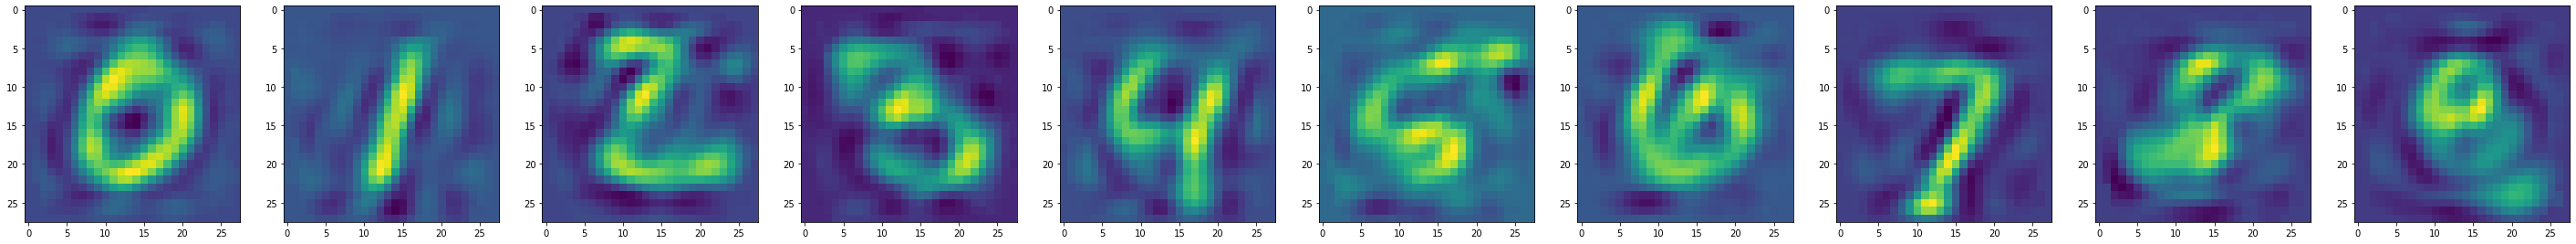

In [13]:
# First row of selected training digits
f,ax = plt.subplots(1,10,figsize=(50,50))
for idx,digit in enumerate(trainDigitList):
    ax[idx].imshow(trainingData[digit-1].reshape(28,28))
plt.show()

# Second row of reconstructed selected test digits
f,ax = plt.subplots(1,10,figsize=(50,50))
for idx in range(10):
    ax[idx].imshow(reconstructedTestDigits[idx].reshape(28,28))
plt.show()

# (c) Using Eigen-digits to Classify each digit image

In [14]:
# Standardize training dataset
trainingStd = StandardScaler().fit_transform(trainingData)
# Standardize test dataset
testStd = StandardScaler().fit_transform(testData)

# Calculate mean of the training dataset
trainingMean = np.mean(trainingStd, axis=0)

# Normalize train and test datasets by subtracting training mean.
normedTrain = np.subtract(trainingStd,trainingMean)
normedTest = np.subtract(testStd,trainingMean)

In [15]:
# Extract top30 eigenvectors from the sorted array of tuples we had created above.
top30EigenVecs = []
for i in range(TOP_EIGENVECTORS):
    top30EigenVecs.append(eigenValVec[i][1])
top30EigenVecs = np.asarray(top30EigenVecs)

print ("*****************************")
print ("top30EigenVecs shape:", top30EigenVecs.shape)
print ("*****************************")

*****************************
top30EigenVecs shape: (30, 784)
*****************************


## Project training datapoints into the subspace spanned by top 30 eigenvectors 

In [16]:
# Project training datapoints into the subspace spanned by top 30 eigenvectors 

# Loop through each training digits
for idx, digit in enumerate(normedTrain):
    # Calculate lambda by multiplying each sample with eigenvectors.
    lambdas = []
    for i in range(TOP_EIGENVECTORS):
        lambdas.append(normedTrain[idx].T.dot(eigenValVec[i][1]))

    # reconstruct each test digit by the sum of the product between the λi and top 30 eigenvectors
    digitNew = np.zeros(784)
    for i in range(TOP_EIGENVECTORS):
        digitNew += lambdas[i]*eigenValVec[i][1]
    normedTrain[idx] = digitNew

# Project training datapoints into the subspace spanned by top 30 eigenvectors    
normedTrain = np.dot(normedTrain,top30EigenVecs.T)
print ("************************************")
print ("normedTrain shape:",normedTrain.shape)
print ("************************************")

************************************
normedTrain shape: (60000, 30)
************************************


## Project test datapoints into the subspace spanned by top 30 eigenvectors

In [17]:
# Project test datapoints into the subspace spanned by top 30 eigenvectors

# Loop through each test digits
for idx, digit in enumerate(normedTest):
    # Calculate lambda by multiplying each sample with eigenvectors.
    lambdas = []
    for i in range(TOP_EIGENVECTORS):
        lambdas.append(normedTest[idx].T.dot(eigenValVec[i][1]))

    # reconstruct each test digit by the sum of the product between the λi and top 30 eigenvectors
    digitNew = np.zeros(784)
    for i in range(TOP_EIGENVECTORS):
        digitNew += lambdas[i]*eigenValVec[i][1]
    normedTest[idx] = digitNew

# Project training datapoints into the subspace spanned by top 30 eigenvectors    
normedTest = np.dot(normedTest,top30EigenVecs.T)

print ("************************************")
print ("normedTest shape:",normedTest.shape)
print ("************************************")


************************************
normedTest shape: (10000, 30)
************************************


# (c) (1) Linear Regression

## Sort the training data (prepare for Y matrix)

In [18]:
# sort the training data based on training labels. It will be used to generate Y matrix for linear regression.
sortedNormedTrain = []
for i in range(0,60000,1):
    sortedNormedTrain += (normedTrain[trainingLabels==i].tolist())

# Convert it to nparray
sortedNormedTrain = np.asarray(sortedNormedTrain)

# Make sure the shape hasn't changed.
print ("*********************************")
print ("sortedNormedTrain shape:", sortedNormedTrain.shape)
print ("*********************************")

*********************************
sortedNormedTrain shape: (60000, 30)
*********************************


## Sort the training labels.

In [19]:
# Sort the training labels because we have sorted the training data. It will be used to calculate the accuracy.
sortedTrainLabels = np.sort(trainingLabels)

# print sorted labels
print ("sortedTrainLabels: ", sortedTrainLabels)
print ("************************************")
print ("sortedTrainLabels shape:", sortedTrainLabels.shape)
print ("************************************")

sortedTrainLabels:  [0 0 0 ... 9 9 9]
************************************
sortedTrainLabels shape: (60000,)
************************************


## Generate Y matrix

In [20]:
# Generate a Y matrix by appending 1's column to sorted and normalized training data
if INCLUDE_BIAS:
    Y = np.append(sortedNormedTrain,np.ones(60000,dtype=int).reshape(60000,1),axis=1)
else:
    Y = sortedNormedTrain
print ("************************************")
print ("Y's shape:", Y.shape)
print ("************************************")

************************************
Y's shape: (60000, 31)
************************************


## Generate B matrix.

In [21]:
# Create a zero matrix of size NxC (N = # of training data, C = # of class labels in training data)
B = np.zeros((sortedTrainLabels.size, sortedTrainLabels.max()+1))
# Put a 1 in class position in each row, to create a one-hot encoded B matrix
B[np.arange(sortedTrainLabels.size),sortedTrainLabels] = 1
# print B's shape
print ("************************")
print ("B's shape: ", B.shape)
print ("************************")
print ("B Matrix:\n",B,"\n")
print ("************************")

************************
B's shape:  (60000, 10)
************************
B Matrix:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]] 

************************


## Generate A matrix

In [22]:
# Generate a pseudo inverse matrix of Y and then multiply with B to generate A matrix.
A = np.linalg.pinv(Y).dot(B)
print ("************************")
print ("A's shape: ", A.shape) 
print ("************************")

************************
A's shape:  (31, 10)
************************


In [23]:
# Get A's transpose matrix, it will be useful in next steps.
AT = A.T
print ("************************")
print ("AT's shape: ", AT.shape) 
print ("************************")

************************
AT's shape:  (10, 31)
************************


## Predict training labels using Linear Regression 

In [24]:
# prepare a list of predicted labels. We will compare this list against actual training labels to calculate accuracy.
predictedLabel = []

# Run Linear Regression on each training sample.
for j in range(60000):
    # prepare a list of results for each digit from 0 to 9.
    result = []
    
    # Loop through each digit label and run Linear Regression. Append the output to "result" list.
    for i in range(10):
        result.append(AT[i].T.dot(Y[j]))
    
    # Choose the class with highest probability
    predictedLabel.append(result.index(max(result)))

# Covert it to an nparray
predictedLabels = np.asarray(predictedLabel)

print ("***********************************")
print ("predictedLabels's shape: ", predictedLabels.shape)
print ("***********************************")

***********************************
predictedLabels's shape:  (60000,)
***********************************


## Find number of accurate predictions and calculate accuracy

In [25]:
# Find total number of accurate results
accuratePredictions = np.sum(sortedTrainLabels==predictedLabels)

# Calculate accuracy %
trainAccuracy = (accuratePredictions/60000)*100

# print accuracy %
print ("***************************")
print ("Training accuracy: ", trainAccuracy.round(2))
print ("***************************")

***************************
Training accuracy:  80.67
***************************


## Generate Y matrix for test data

In [26]:
# Append column of 1's at the end of normalized test data. This is similar to Y matrix we generated for training data.
if INCLUDE_BIAS:
    yTest = np.append(normedTest,np.ones(10000,dtype=int).reshape(10000,1),axis=1)
else:
    yTest = normedTest
print ("*******************************")
print ("yTest's shape: ", yTest.shape) 
print ("*******************************")

*******************************
yTest's shape:  (10000, 31)
*******************************


## Predict test labels using Linear Regression

In [27]:
# prepare a list of predicted labels. We will compare this list against actual training labels to calculate accuracy.
predictedLabel = []

# Run Linear Regression on each test sample.
for j in range(10000):
    # prepare a list of results for each digit from 0 to 9.
    result = []
    
    # Loop through each digit label and run Linear Regression. Append the output to "result" list.
    for i in range(10):
        result.append(AT[i].T.dot(yTest[j]))
    
    # Choose the class with highest probability
    predictedLabel.append(result.index(max(result)))

# Covert it to an nparray
predictedLabels = np.asarray(predictedLabel)

print ("***********************************")
print ("predictedLabels's shape: ", predictedLabels.shape)
print ("***********************************")

***********************************
predictedLabels's shape:  (10000,)
***********************************


## Find number of accurate predictions and calculate accuracy

In [28]:
# Find total number of accurate results
accuratePredictions = np.sum(testLabels==predictedLabels)

# Calculate accuracy %
testAccuracy = (accuratePredictions/10000)*100

# print accuracy %
print ("***************************")
print ("Test accuracy: ", testAccuracy.round(2))
print ("***************************")

***************************
Test accuracy:  81.44
***************************


# (c) (2) Polynomial Regression

## Generate a Y matrix for Polynomial Regression

In [29]:
# Create a list for Y matrix used in Polynomial Regression
poly_Y = []

for y in (Y):
    # Generate combinations of polynomial terms based on polynomial order.
    combinations = np.asarray(list(combinations_with_replacement(y,POLYNOMIAL_ORDER)))
    # Get a product of each combination
    prodCombinations = np.prod(combinations,axis=1)
    # Append each product to polynomial Y matrix
    poly_Y.append(prodCombinations)

# Convert it to nparray type.
poly_Y = np.asarray(poly_Y)

print ("***************************")
print ("Y's shape: ", poly_Y.shape)
print ("***************************")

***************************
Y's shape:  (60000, 496)
***************************


## Generate A matrix for Polynomial Regression

In [30]:
# Generate A matrix for polynomial regression
poly_A = np.linalg.pinv(poly_Y).dot(B)

print ("***************************")
print ("A's shape: ", poly_A.shape)
print ("***************************")

***************************
A's shape:  (496, 10)
***************************


### Transpose A matrix. It will be used during Polynomial Regression classification.

In [31]:
# Get A's transpose matrix, it will be useful in next steps.
poly_AT = poly_A.T

print ("***************************")
print ("A transpose shape: ", poly_AT.shape)
print ("***************************")

***************************
A transpose shape:  (10, 496)
***************************


## Predict training labels using Polynomial Regression

In [32]:
# prepare a list of predicted labels. We will compare this list against actual training labels to calculate accuracy.
predictedLabel = []

# Run Polynomial Regression on each training sample.
for j in range(60000):
    # prepare a list of results for each digit from 0 to 9.
    result = []
    
    # Loop through each digit label and run Polynomial Regression. Append the output to "result" list.
    for i in range(10):
        result.append(poly_AT[i].T.dot(poly_Y[j]))
    
    # Choose the class with highest probability
    predictedLabel.append(result.index(max(result)))

# Covert it to an nparray
predictedLabels = np.asarray(predictedLabel)

print ("***********************************")
print ("predictedLabels's shape: ", predictedLabels.shape)
print ("***********************************")

***********************************
predictedLabels's shape:  (60000,)
***********************************


## Find number of accurate predictions and calculate accuracy

In [33]:
# Find total number of accurate results
accuratePredictions = np.sum(sortedTrainLabels==predictedLabels)

# Calculate accuracy %
trainAccuracy = (accuratePredictions/60000)*100

# print accuracy %
print ("***************************")
print ("Training accuracy: ", trainAccuracy.round(2))
print ("***************************")

***************************
Training accuracy:  94.0
***************************


## Generate Y matrix for test data for Polynomial Regression

In [34]:
# Create a list for Y matrix used in Polynomial Regression
poly_yTest = []

for y in (yTest):
    # Generate combinations of polynomial terms based on polynomial order.
    combinations = np.asarray(list(combinations_with_replacement(y,POLYNOMIAL_ORDER)))
    # Get a product of each combination
    prodCombinations = np.prod(combinations,axis=1)
    # Append each product to polynomial Y matrix
    poly_yTest.append(prodCombinations)

# Convert it to nparray type.
poly_yTest = np.asarray(poly_yTest)

print ("***************************")
print ("Y's shape: ", poly_yTest.shape)
print ("***************************")

***************************
Y's shape:  (10000, 496)
***************************


## Predict test labels using Polynomial Regression

In [35]:
# prepare a list of predicted labels. We will compare this list against actual training labels to calculate accuracy.
predictedLabel = []

# Run Linear Regression on each test sample.
for j in range(10000):
    # prepare a list of results for each digit from 0 to 9.
    result = []
    
    # Loop through each digit label and run Linear Regression. Append the output to "result" list.
    for i in range(10):
        result.append(poly_AT[i].T.dot(poly_yTest[j]))
    
    # Choose the class with highest probability
    predictedLabel.append(result.index(max(result)))

# Covert it to an nparray
predictedLabels = np.asarray(predictedLabel)

print ("***********************************")
print ("predictedLabels's shape: ", predictedLabels.shape)
print ("***********************************")

***********************************
predictedLabels's shape:  (10000,)
***********************************


## Find number of accurate predictions and calculate accuracy

In [36]:
# Find total number of accurate results
accuratePredictions = np.sum(testLabels==predictedLabels)

# Calculate accuracy %
testAccuracy = (accuratePredictions/10000)*100

# print accuracy %
print ("***************************")
print ("Test accuracy: ", testAccuracy.round(2))
print ("***************************")

***************************
Test accuracy:  93.9
***************************


# (d) Possible techniques/tricks to improve the test accuracy.

In general, Polynomial regression gives better accuracy compared to Linear Regression. However, Polynomial Regression has higher execution time compared to Linear Regression.

We can increase the test accuracy using following techniques.

**1)	Increase number of Eigenvectors**

We can increase the accuracy by Increasing the number of eigenvectors. We can simply modify **TOP_EIGENVECTORS** constant to modify the number of top eigenvectors.
 
The accuracy improves as we use higher than 30 dimensional eigen-digits. Following table shows the test accuracy with different eigen-digit dimensions. The execution time also increases drastically as we increase number of eigen vectors. Hence, we have to find a balance between accuracy and execution time.

![Eigenvectors_Performance](img/Eigenvector_results.png)


**2)	Increase Polynomial Order**

We can increase the test accuracy by increasing the Polynomial Order. The execution time also increases dramatically with increasing Polynomial Order. This is because the number of combinations of polynomial terms in the discriminant function increases exponentially with increasing polynomial order.
We can modify the polynomial order by simply modifying **POLYNOMIAL_ORDER** constant.

The accuracy improves as we use higher order Polynomial Regression. Following table shows the test accuracy with different Polynomial orders. The execution time also increases significantly as we increase the Polynomial order. Hence, we have to find a balance between accuracy and execution time.

![PolyOrder_Performance](img/PolyOrder_results.png)

**3)	Including Bias term**
Bias term helps to increase the accuracy for Polynomial Regression. We can include or remove bias term by simply modifying **INCLUDE_BIAS** constant. It was observed that including Bias term improves the test accuracy slightly.

![Bias](img/Bias_results.png)

